In [ ]:
# --- Bloomberg Excel loader (connection-based; per-row inserts) ---
# this code runs in conjuction with the Price_History_HC sheet - it takes a couple of minutes to run
# this sheet is a copy and paste from the UK_markets_analysis sheet
# version 1 - JCB 20250912
#
# look  to connect directly to Bloomberg

import sys, sqlite3
sys.path.append("/Users/jcb/Documents/bond_project")  # adjust if needed

import pandas as pd
from datetime import datetime, timedelta

from database.query import resolve_isin_from_alt_id
from database.insert import insert_instrument_data   # expects ONE InstrumentData
from models.instrument_data import InstrumentData

DB_PATH   = "/Volumes/PROJECT_JCB/bond_project/jcb_db.db"
FILE_PATH = "Price_History_HC.xlsx"

# Config
PRICE_AS_CLEAN = True      # PX_LAST -> 'clean_price' (else 'price')
SESSION        = "close"   # mark close session in attrs
RESOLUTION     = "daily"   # your queries expect 'daily'
BATCH_SIZE     = 5000      # just controls memory; inserts are still per-row

def excel_serial_to_date(serial):
    return (datetime(1899, 12, 30) + timedelta(days=float(serial))).date()

def clean_date(cell):
    try:
        if isinstance(cell, (int, float)) and 10000 < float(cell) < 60000:
            return excel_serial_to_date(cell)
        d = pd.to_datetime(cell, errors="coerce")
        return None if pd.isna(d) else d.date()
    except Exception:
        return None

def map_bbg_dtype(raw: str) -> str:
    r = (raw or "").strip().lower()
    if r == "yld_ytm_mid":
        return "yield"
    if r == "px_dirty_mid":
        return "dirty_price"
    if r == "px_last":
        return "clean_price" if PRICE_AS_CLEAN else "price"
    # extend mappings as needed (e.g., DUR_MID -> duration_modified)
    return r or "price"

def unit_for_dtype(dt: str):
    if dt == "yield": return "percent"
    if dt in ("clean_price","dirty_price","price"): return "per_100"
    if dt in ("z_spread","ois_oas"): return "bps"
    if dt in ("duration_modified","modified_duration"): return "years"
    return None

# Load workbook (4-column block layout)
df = pd.read_excel(FILE_PATH, header=None)

start_col = 2
errors   = []
inserted = 0
skipped  = 0
batch    = []

def flush_batch(conn, batch):
    global inserted, skipped
    for row in batch:
        try:
            res = insert_instrument_data(conn, row)  # your helper expects ONE InstrumentData
            inserted += 1 if res == "inserted" else 0
            skipped  += 1 if res != "inserted" else 0
        except Exception as e:
            errors.append(f"{row.instrument_id} @ {row.data_date}: {e}")

conn = sqlite3.connect(DB_PATH)
try:
    # sensible PRAGMAs
    conn.execute("PRAGMA foreign_keys=ON;")
    conn.execute("PRAGMA journal_mode=WAL;")
    conn.execute("PRAGMA synchronous=NORMAL;")
    conn.execute("PRAGMA busy_timeout=5000;")

    conn.execute("BEGIN;")

    col = start_col
    while col < df.shape[1]:
        try:
            bloomberg_code = str(df.iloc[4, col]).strip()
            short_code     = str(df.iloc[5, col]).strip()
            data_type_raw  = str(df.iloc[6, col]).strip()
            data_type      = map_bbg_dtype(data_type_raw)

            # Resolve ISIN using the SAME connection
            isin = resolve_isin_from_alt_id(conn, bloomberg_code, source="Bloomberg")
            if not isin:
                errors.append(f"{bloomberg_code}: ISIN not found")
                col += 4
                continue

            date_series  = df.iloc[10:, col]
            value_series = df.iloc[10:, col + 1]

            for date_cell, value_cell in zip(date_series, value_series):
                d = clean_date(date_cell)
                if d is None or pd.isna(value_cell):
                    continue
                try:
                    val = float(value_cell)
                except Exception:
                    continue

                batch.append(InstrumentData(
                    instrument_id=isin,
                    data_date=d,
                    data_type=data_type,
                    value=val,
                    source="Bloomberg",
                    resolution=RESOLUTION,
                    unit=unit_for_dtype(data_type),
                    attrs={"session": SESSION}
                ))

                if len(batch) >= BATCH_SIZE:
                    flush_batch(conn, batch)
                    batch.clear()

        except Exception as outer_e:
            errors.append(f"Column {col}: {outer_e}")

        col += 4  # next block

    if batch:
        flush_batch(conn, batch)
        batch.clear()

    conn.execute("COMMIT;")
except Exception as e:
    conn.execute("ROLLBACK;")
    raise
finally:
    conn.close()

print("✅ Finished loading Bloomberg historical data (connection-based, per-row insert).")
print(f"   Inserted: {inserted} | Skipped: {skipped} | Errors: {len(errors)}")
for e in errors[:10]:
    print(" -", e)
if len(errors) > 10:
    print(f"   ...and {len(errors)-10} more.")

In [ ]:
# --- Tradeweb csv loader (connection-based; per-row inserts) ---
# this code runs in conjuction with the Tradeweb exports sheet - it takes a couple of minutes to run
# version 1 - JCB 20250912
#
# look have an automated way to download the data from Tradeweb

from database.db import get_conn
from database.normalise_types import seed_mappings  # ensure up-to-date aliases
from loaders.load_tradeweb import load_tradeweb_csv_mapped

DB_PATH = "jcb_db.db"
CSV = "E:/bond_project/tradeweb_data/tradeweb_GB00B1VWPJ53.csv"

# 0) refresh mappings (includes Tradeweb aliases)
with get_conn(DB_PATH) as conn:
    seed_mappings(conn)

# 1) Dry-run (no inserts): confirms parsing + mapping coverage
load_tradeweb_csv_mapped(CSV, DB_PATH, dry_run=True)

# 2) Real load (canonical types written directly to instrument_data)
ins, skip, err, n_unmapped = load_tradeweb_csv_mapped(CSV, DB_PATH, allow_unmapped=False)

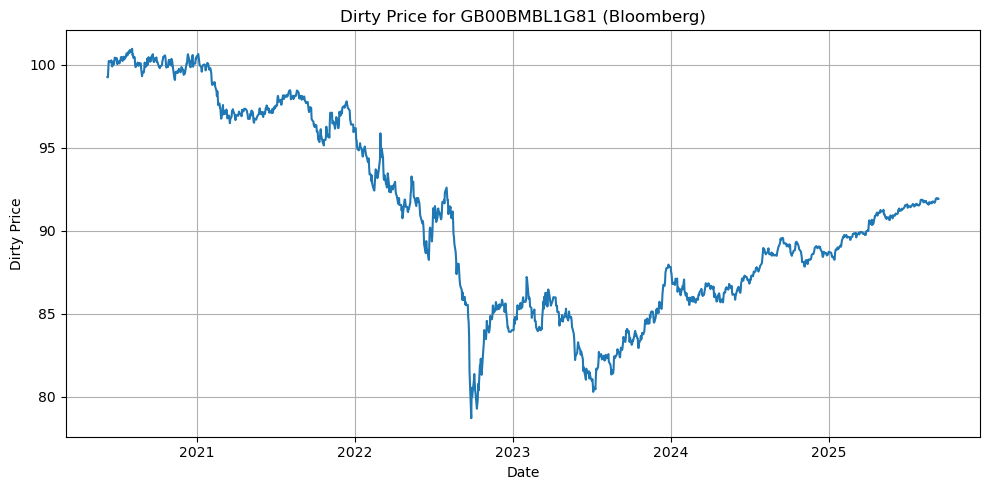

In [ ]:
# A graphing tool that gets data from the jcb_db database
# Verion 1 - JCB 20250912
#
# Look to have a more interactive plotting tool on the internet


import pandas as pd
import matplotlib.pyplot as plt

import importlib
import database.query  # for reload during iterative dev
importlib.reload(database.query)

from database.db import get_conn
from database.query import load_instrument_data

DB_PATH = "jcb_db.db"

def plot_instrument_timeseries(isin: str, source: str, data_type: str = "yield", db_path: str = DB_PATH):
    # open/commit/close handled here (top level)
    with get_conn(db_path) as conn:
        df = load_instrument_data(
            conn,
            instrument_id=isin,
            source=source,
            data_type=data_type,     # e.g. "yield", "clean_price", "dirty_price", ...
            long_format=True,        # default; included for clarity
            parse_dates=False        # we'll parse below
        )

    if df.empty:
        print(f"❌ No data found for ISIN {isin} and type '{data_type}'.")
        return

    # ensure datetime for plotting
    df["data_date"] = pd.to_datetime(df["data_date"], errors="coerce")

    plt.figure(figsize=(10, 5))
    plt.plot(df["data_date"], df["value"])
    plt.title(f"{data_type.replace('_', ' ').title()} for {isin} ({source})")
    plt.xlabel("Date")
    plt.ylabel(data_type.replace('_', ' ').title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# example call
# If your stored data types are "clean_price"/"dirty_price", use one of those instead of "price"
plot_instrument_timeseries("GB00BMBL1G81", source="Bloomberg", data_type="dirty_price")